# Pelican Data Extract and 3D Velocity Calculations
*Eric G. Suchanek, Ph.D. 3/15/19*

This code performs a Gaia rectangular search from 20h50m18s, 44d13m30s to 20h51m22s 44d25m0s and extracts:
* ra, dec, pmra, pmdec, pmra_error, pmdec_error, parallax, parallax_error, g_mean_mag

The Radial_velocities were generally unavailable. No variability data was available either for this query. As a result I changed the query to not pull these fields. 3d velocities were calculated per the formulae discussed in: http://www.astronexus.com/a-a/motions-long-term. These values were then written out to a csv file containing the query results.

In [1]:
#
# Setup the libraries. 

import astropy.units as u
import astropy.coordinates as coord

from astropy.coordinates import Latitude, Longitude, Angle, SkyCoord
#from astropy.units import Quantity

from astroquery.gaia import Gaia
from astropy.visualization import astropy_mpl_style, quantity_support
#import aplpy
from astropy.io import ascii
import numpy as np
import time
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

import progressbar

from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

from pandas import read_csv

from egs import compute_pm_angles

%matplotlib inline

# Suppress warnings. Comment this out if you wish to see the warning messages
import warnings
warnings.filterwarnings('ignore')

# Bruce's search parameters - area 1

_ra1 = "20h50m18s" # 300.8383
_dec1 = "44d13m30s" # 44.225

_ra2 = "20h51m22s" # 300.8561
_dec2 = "44d25m0s" # 44.41667

# this will do the math to calculate the angular
# width of the query box
ra1 = Longitude(_ra1,unit=u.hourangle)
ra2 = Longitude(_ra2, unit=u.hourangle)

dec1 = Latitude(_dec1,unit=u.degree)
dec2 = Latitude(_dec2,unit=u.degree)

ra_diff = ra2 - ra1
dec_diff = dec2 - dec1 
ra_center = ra1 + ra_diff / 2
dec_center = dec1 + dec_diff / 2

"""
print(ra1.deg, dec1.deg)
print(ra2.deg, dec2.deg)
print(ra_center.deg, dec_center.deg)

print(ra_diff.deg, dec_diff.deg)

"""

Created TAP+ (v1.0.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443
312.57499999999993 44.225
312.84166666666664 44.416666666666664
312.70833333333326 44.32083333333333
0.2666666666667083 0.19166666666666288


In [2]:
to_deg = 180.0 / np.pi
to_rad = np.pi / 180.0

# raw string from Gaia
q_str = "SELECT TOP 999999 gaia_source.source_id,gaia_source.ra,gaia_source.ra_error,\
gaia_source.dec,gaia_source.dec_error,gaia_source.parallax,gaia_source.parallax_error,\
gaia_source.pmra,gaia_source.pmra_error,gaia_source.pmdec,gaia_source.pmdec_error,\
gaia_source.phot_g_mean_mag,gaia_source.radial_velocity,gaia_source.radial_velocity_error,\
gaia_source.phot_variable_flag FROM gaiadr2.gaia_source  \
WHERE CONTAINS(POINT('ICRS',gaiadr2.gaia_source.ra,gaiadr2.gaia_source.dec),\
BOX('ICRS',312.7083333333333,44.32083333333333,0.2666666666666515,0.19166666666666288))=1  "


# only pull non-null parallax, pmra, and pmdec
sel_str_box2 = "SELECT TOP 2000 gaia_source.source_id,gaia_source.ra,gaia_source.ra_error,\
gaia_source.dec,gaia_source.dec_error,gaia_source.parallax,gaia_source.parallax_error,\
gaia_source.pmra,gaia_source.pmra_error,gaia_source.pmdec,gaia_source.pmdec_error,\
gaia_source.phot_g_mean_mag FROM gaiadr2.gaia_source  \
WHERE CONTAINS(POINT('ICRS',gaiadr2.gaia_source.ra,gaiadr2.gaia_source.dec),BOX('ICRS',{},{},{},{}))=1 \
AND gaia_source.parallax IS NOT NULL \
AND gaia_source.pmra IS NOT NULL \
AND gaia_source.pmdec IS NOT NULL ;"

sel_str_box = "SELECT TOP 2000 * FROM gaiadr2.gaia_source  \
WHERE CONTAINS(POINT('ICRS',gaiadr2.gaia_source.ra,gaiadr2.gaia_source.dec),BOX('ICRS',{},{},{},{}))=1 \
AND gaia_source.parallax IS NOT NULL \
AND gaia_source.pmra IS NOT NULL \
AND gaia_source.pmdec IS NOT NULL;"


sel_str_box_id_restricted = "SELECT TOP 2000 * FROM gaiadr2.gaia_source  \
WHERE CONTAINS(POINT('ICRS',gaiadr2.gaia_source.ra,gaiadr2.gaia_source.dec),BOX('ICRS',{},{},{},{}))=1 \
AND gaia_source.parallax IS NOT NULL \
AND gaia_source.pmra IS NOT NULL \
AND gaia_source.pmdec IS NOT NULL \
AND gaia_source.solution_id = {};"

sel_str_box_id_all = "SELECT TOP 2000 * FROM gaiadr2.gaia_source  \
WHERE CONTAINS(POINT('ICRS',gaiadr2.gaia_source.ra,gaiadr2.gaia_source.dec),BOX('ICRS',{},{},{},{}))=1 \
AND gaia_source.solution_id = {};"

from egs import compute_3d_velocities
from egs import compute_3d_velocities_pc

project_name = "./area1/PelPM_"

data_filename = project_name + _ra1 + "_" + _dec1 + "_" + _ra2 + "_" + _dec2 + "_" + "_deg.csv"
vel_filename =  project_name + _ra1 + "_" + _dec1 + "_" + _ra2 + "_" + _dec2 + "_deg_vel_out.csv"

q = str.format(sel_str_box,312.708333,44.3208333,0.2666667,0.1966667)
job = Gaia.launch_job_async(query=q, dump_to_file=True, 
                            output_file=data_filename, output_format='csv')
stars = job.get_results()
star_count = len(stars)  # global variable

# all in mas, convert to arcsecs
pmra = stars['pmra'] / 1000.0
pmdec = stars['pmdec'] / 1000.0
parallax = stars['parallax'] / 1000.0
_ra = stars['ra']
_dec = stars['dec']

# convert to long and lat to get the units right
ra = Longitude(stars['ra'],unit=u.deg)
dec = Latitude(stars['dec'],unit=u.deg)

print(str.format("Returned: {} stars", star_count))
# velocities
vx = []
vy = []
vz = []

# compute the velocity vectors
vx, vy, vz = compute_3d_velocities_pc(ra, dec, pmra, pmdec, parallax)
data = read_csv(data_filename)

# add new columns to the data for velocities
data['VX'] = vx
data['VY'] = vy
data['VZ'] = vz

# write the file
data.to_csv(vel_filename)
print('Done.')
print(q)


Returned: 912 stars
Done.
SELECT TOP 2000 * FROM gaiadr2.gaia_source  WHERE CONTAINS(POINT('ICRS',gaiadr2.gaia_source.ra,gaiadr2.gaia_source.dec),BOX('ICRS',312.708333,44.3208333,0.2666667,0.1966667))=1 AND gaia_source.parallax IS NOT NULL AND gaia_source.pmra IS NOT NULL AND gaia_source.pmdec IS NOT NULL;


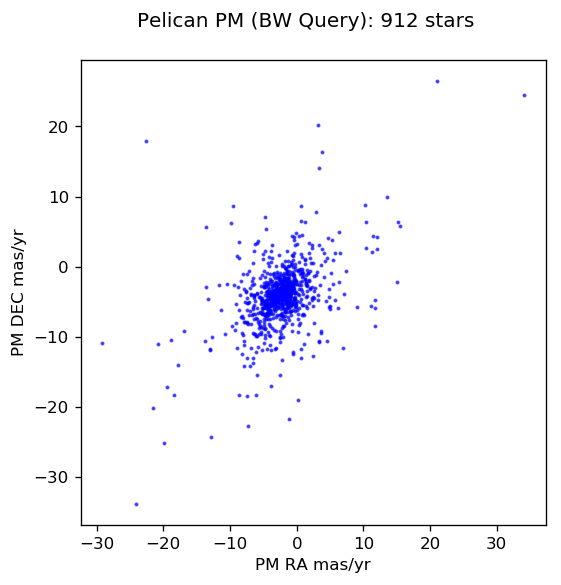

In [5]:
# scatter plot
fig, ax = plt.subplots(figsize=(5,5),dpi=120)

ax.scatter(stars['pmra'], stars['pmdec'], color='b', alpha=0.6, s=2)

fig.subplots_adjust(top=0.90)
fig.suptitle('Pelican PM (BW Query): ' + str(len(stars))+ ' stars', 
             fontsize=12)
# ax.set_title('axes title')
ax.set_xlabel('PM RA mas/yr')
ax.set_ylabel('PM DEC mas/yr')

plt.show()
plt.close()

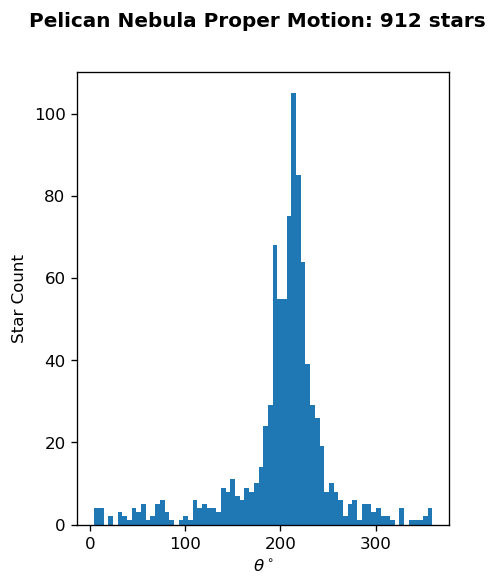

In [6]:

fig3, ax3 = plt.subplots(figsize=(4,5),dpi=120)
fig3.suptitle('Pelican Nebula Proper Motion: '+ str(len(stars))+ ' stars', 
              fontsize=12, fontweight='bold')

ax3.set_xlabel(r"$\theta^\circ$")
ax3.set_ylabel('Star Count')

to_deg = 180.0 / np.pi
n_bins = 72
x = []

x = compute_pm_angles(stars)
ax3.hist(x, bins=n_bins)

plt.show()



In [7]:
#ipywidgets-display::
# Parallax 3D Quiver
import ipyvolume as ipv
import numpy as np
from ipywidgets import FloatSlider, ColorPicker, VBox, jslink

# returns the extents of each input vector shunk by sh (decimal percent)
def myshrink(X,Y,Z,sh):
    xmin = np.min(X)
    xmax = np.max(X)
    ymin = np.min(Y)
    ymax = np.max(Y)
    zmin = np.min(Z)
    zmax = np.max(Z)
    zmin2 = zmin - sh * zmin
    zmax2 = zmax + sh * zmax
    xmin2 = xmin - sh * xmin
    xmax2 = xmax + sh * xmax
    ymin2 = ymin + sh * ymax
    ymax2 = ymax + sh * ymax
    
    return xmin,xmax,ymin,ymax,zmin,zmax

X = stars['ra']
Y = stars['dec']
Z = stars['parallax']

pmra = stars['pmra']
pmdec = stars['pmdec']
parallax = stars['parallax']

# velocities
vx = []
vy = []
vz = []

# compute the velocity vectors
vx, vy, vz = compute_3d_velocities(ra,dec,pmra,pmdec,parallax)

_figwidth = 600
_figheight = 600

sh = .05 # percentage to shrink the min/max - the plot fails unless we do this
xmin,xmax,ymin,ymax,zmin,zmax = myshrink(X, Y, Z, sh)

# 3d quiver with ipyvolume
ipv.clear()
ipv.figure(width=_figwidth,height=_figheight)
ipv.xyzlabel('RA','Dec', 'Parallax')
ipv.xlim(xmin,xmax)
ipv.ylim(ymin,ymax)
ipv.zlim(zmin,zmax)

quiv3 = ipv.quiver(X,Y,Z,vx,vy,vz,size=4,size_selected=8)

selected = []
size = FloatSlider(min=0, max=30, step=0.1)
size_selected = FloatSlider(min=0, max=30, step=0.1)
color = ColorPicker()
color_selected = ColorPicker()

jslink((quiv3, 'size'), (size, 'value'))
jslink((quiv3, 'color'), (color, 'value'))
VBox([ipv.gcc(), size, color])

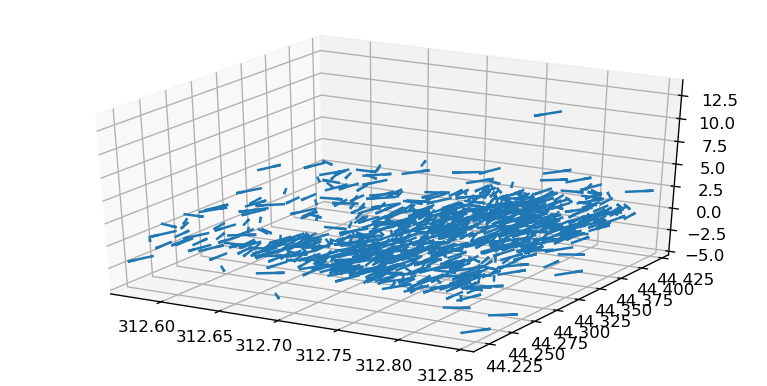

In [8]:
# Plot a 3D quiver plot
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(8,4),dpi=120)
ax = plt.subplot(111, projection="3d")
#ax = fig.gca(projection='3d')

X = stars['ra']
Y = stars['dec']
Z = stars['parallax']
pmra = stars['pmra']
pmdec = stars['pmdec']
parallax = stars['parallax']

# velocities
vx = []
vy = []
vz = []

# compute the velocity vectors
vx, vy, vz = compute_3d_velocities(ra,dec,pmra,pmdec,parallax)

ax.quiver(X, Y, Z, vx, vy, vz, length=0.02, normalize=True)

plt.show()